<a href="https://colab.research.google.com/github/Anggara-Group/Learning-and-tutorials/blob/main/Image%20analysis/Image_load_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Anggara-Group/Learning-and-tutorials.git

Cloning into 'Learning-and-tutorials'...
remote: Enumerating objects: 1890, done.
remote: Counting objects: 100% (1890/1890), done.
remote: Compressing objects: 100% (1637/1637), done.
remote: Total 1890 (delta 283), reused 1827 (delta 237), pack-reused 0 (from 0)
Receiving objects: 100% (1890/1890), 23.04 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (283/283), done.


In [2]:
import os
import pickle
from pathlib import Path

In [3]:
os.chdir('/content/Learning-and-tutorials/Image analysis')

In [4]:
!pip install nanonispy2
!pip install opencv-python

In [5]:
# Third-party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Image processing imports
from skimage.io import imread
from skimage.util import img_as_ubyte

# Local module imports
from src.automated_analysis import *
from src.display_functions import *
from src.filters import *
from src.sxm_loader import *
from src.utils import *
from src.clustering import *

In [6]:
paths = load_paths('paths.json')

if paths:
    general_path = paths['input_paths']['general_path']
    saving_path = paths['output_paths']['saving_path']
    info_path = paths['info_folder']['info_path']
else:
    print("Failed to load paths")

In [7]:
data_folder = os.path.join(general_path, info_path)
result_folder = os.path.join(saving_path, info_path)

os.makedirs(result_folder, exist_ok=True)
print(f" Created directory: {result_folder}")

 Created directory: Results/Test


In [8]:
#Open all sxm files

files = os.listdir(data_folder)
sxm_data = {}

for file in files:
    if file.endswith(".sxm"):
        file_path = os.path.join(data_folder, file)
        filename_without_ext = os.path.splitext(file)[0]
        sxm_data[filename_without_ext] = load_sxm_file(file_path)

In [9]:
#Get  names and number of files
names=list(sxm_data.keys())
n_files = len(names)

In [10]:
names

['240314_Cu1000391', '240314_Cu1000392', '240314_Cu1000390']

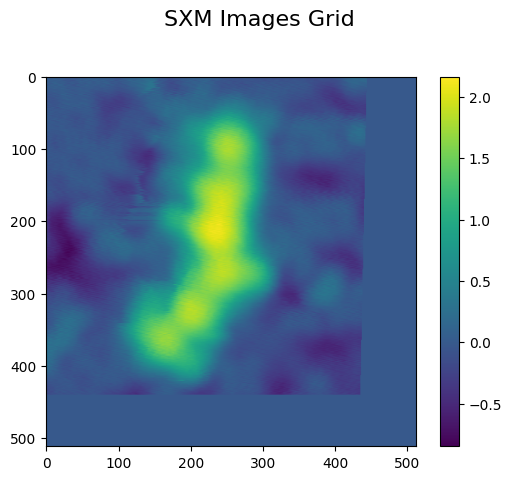

In [11]:
# Check one file to see what your data looks like
# MODIFY THIS: Change the name to one of your files
name='240314_Cu1000390'
plt.imshow(sxm_data[name]['img'], cmap='viridis')
plt.suptitle('SXM Images Grid', fontsize=16, y=1.02)
plt.colorbar()
plt.show()

In [12]:
# Extract numerical features from all images for clustering
# This calculates things like contrast, entropy, edge density, etc.
feature_frame = extract_features_to_dataframe(sxm_data, target_size=(128, 128), include_image_pixels=False)



DataFrame created with shape: (3, 23)
Features: ['bias', 'acq_time', 'max_intensity', 'min_intensity', 'intensity_range', 'mean_intensity', 'std_intensity', 'intensity_skewness', 'intensity_kurtosis', 'entropy', 'edge_density', 'num_contours', 'contrast', 'homogeneity', 'laplacian_variance', 'gradient_magnitude', 'freq_energy_high', 'freq_energy_low', 'freq_ratio_high_low', 'image_height', 'image_width', 'image_aspect_ratio', 'image_area']


In [13]:
feature_frame

,bias,acq_time,max_intensity,min_intensity,intensity_range,mean_intensity,std_intensity,intensity_skewness,intensity_kurtosis,entropy,...,homogeneity,laplacian_variance,gradient_magnitude,freq_energy_high,freq_energy_low,freq_ratio_high_low,image_height,image_width,image_aspect_ratio,image_area
sample_name,,,,,,,,,,,,,,,,,,,,,
240314_Cu1000391,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,0.53403,1.767348,2.433311,6.002782,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144
240314_Cu1000392,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,0.53403,1.767348,2.433311,6.002782,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144
240314_Cu1000390,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,0.53403,1.767348,2.433311,6.002782,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144


In [14]:
# Make fake different "images" for testing
n_samples = len(feature_frame)
fake_features = pd.DataFrame({
    'feature_1': np.random.normal(0, 1, n_samples),
    'feature_2': np.random.normal(2, 1.5, n_samples),
    'feature_3': np.random.exponential(1, n_samples)
}, index=feature_frame.index)

results = cluster_with_gmm(fake_features, max_clusters=4)

Using features: ['feature_1', 'feature_2', 'feature_3']
After variance filtering (0.01): 3 features
Testing 2 to 4 clusters
Failed to fit 3 clusters: Number of labels is 3. Valid values are 2 to n_samples - 1 (inclusive)
Failed to fit 4 clusters: Expected n_samples >= n_components but got n_components = 4, n_samples = 3
Final silhouette score: 0.365


In [15]:
#Real case
#  results = cluster_with_gmm(
#     feature_frame,
#     variance_threshold=0.01,
#     use_pca=True,
#     max_clusters=5)

In [16]:
# Group similar images together
clusters= results['cluster_labels'].tolist()
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

In [17]:
# Create a dictionary mapping cluster IDs to image names
cluster_dict = {}
for name, cluster in zip(list(results['results_df'].index), results['cluster_labels']):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(name)


In [18]:
# Create folders and save grid plots of original (unprocessed) images
for i in range(n_clusters):
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(result_folder, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_plots_dicts(
        sxm_data,
        cluster_dict,
        clus=i,
        save_path=result_folder,
        image_key='img',
        name_file='classified_unprocessed', # Your base path where cluster folders are
        n_cols=10
    )

Created: Results/Test/cluster_0
Saved cluster 0 plot to: Results/Test/cluster_0/classified_unprocessed_0.png
Created: Results/Test/cluster_1
Saved cluster 1 plot to: Results/Test/cluster_1/classified_unprocessed_1.png


In [19]:
# Generate filter configurations for all clusters
cluster_configs, df, cluster_stats = run_cluster_config_analysis(feature_frame,clusters)

Reasoning:
   FFT Gaussian: Noise reduction/smoothing
Reasoning:
   FFT Gaussian: Noise reduction/smoothing


In [20]:
# Initialize storage for all processed clusters
cluster_processed = {}

# Process each cluster
for cluster_id in range(n_clusters):
    cluster_config = cluster_configs[f'cluster_{cluster_id}_filters']
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        image = sxm_data[name]['img']
        zmask = sxm_data[name]['Zmask']

        try:
            # Apply SXM processing function with cluster-specific config
            result = process_sxm_image(image, zmask, cluster_config)
            processed_image = result['processed_image']
            try:
                image_entropy = calculate_entropy(processed_image)
            except:
                image_entropy = sxm_data[name].get('entropy', 0)

            # Store processed data
            cluster_processed[name] = {
                'original_img': image,
                'processed_img': processed_image,
                'Zmask': zmask,
                'Pixelsize': sxm_data[name]['Pixelsize'],
                'entropy': image_entropy,
                'header': sxm_data[name]['header'],
                'filters_applied': cluster_config.copy(),
                'processing_result': result  # Store full result if needed
            }

        except Exception as e:
            print(f"Error processing {name}: {e}")

            # Store original data if processing fails
            cluster_processed[name] = {
                'original_img': image,
                'processed_img': image,  # Use original as fallback
                'Zmask': zmask,
                'Pixelsize': sxm_data[name]['Pixelsize'],
                'entropy': sxm_data[name].get('entropy', 0),
                'bias': sxm_data[name]['bias'],
                'acq_time': sxm_data[name]['acq_time'],
                'header': sxm_data[name]['header'],
                'filters_applied': {},
                'processing_result': None,
                'error': str(e)
            }

    # Store cluster results
    all_processed_clusters=cluster_processed

In [21]:
# Remove background from processed images using Otsu thresholding
otsus={}
for cluster_id in range(n_clusters):
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        img = all_processed_clusters[name]['processed_img']
        otsus[name]=results = remove_background_outside_edges(img,gauss=False, sensitivity='low')

Low sensitivity: Using 67.9 instead of Otsu 97.0
Low sensitivity: Using 67.9 instead of Otsu 97.0
Low sensitivity: Using 67.9 instead of Otsu 97.0


In [22]:
# Update our main dictionary with background removal results
deep_update(all_processed_clusters, otsus)

In [23]:
# Calculate distance transforms for shape analysis

for cluster_id in range(n_clusters):
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        img = all_processed_clusters[name]['result_black_bg']
        mask = all_processed_clusters[name]['mask']
        distance_array = get_distance_transform(img, mask, name)

        # Store the result
        all_processed_clusters[name].update({
            'distance_transform': distance_array,
            'max_distance': distance_array.max(),
            'mean_distance': distance_array[distance_array > 0].mean() if np.sum(distance_array > 0) > 0 else 0,
            'image_shape': img.shape,
            'non_zero_pixels': np.sum(distance_array > 0)
        })

In [24]:
# Extract molecular backbones and calculate measurements
for cluster_id in range(n_clusters):
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        img = all_processed_clusters[name]['original_img']
        pixelsize = all_processed_clusters[name]['Pixelsize']  # [x_nm_per_pixel, y_nm_per_pixel]
        distance_transform = all_processed_clusters[name]['distance_transform']

        backbone_ridge = extract_backbone_from_distance_transform(img, distance_transform, name, method='ridge')
        measurements = analyze_backbone_measurements(backbone_ridge['backbone_points'], name, pixelsize)

        all_processed_clusters[name]['backbone_ridge'] = backbone_ridge
        all_processed_clusters[name]['measurements'] = measurements

   Ridge method: 1402 backbone points
   Ridge method: 1402 backbone points
   Ridge method: 1402 backbone points


In [25]:
# Save grid plots of different processing stages
for i in range(n_clusters):
    cluster_path = os.path.join(result_folder, f'cluster_{i}')
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

image_types = [
    ('processed_img', 'classified_processed'),
    ('result_black_bg', 'otsu_background'),
    ('distance_transform', 'distance_transform')
]

for image_key, name_file in image_types:
    for cluster_id in range(n_clusters):
        save_plots_dicts(
            all_processed_clusters,
            cluster_dict,
            clus=cluster_id,
            save_path=result_folder,
            image_key=image_key,
            name_file=name_file,
            n_cols=10
        )

Created: Results/Test/cluster_0
Created: Results/Test/cluster_1
Saved cluster 0 plot to: Results/Test/cluster_0/classified_processed_0.png
Saved cluster 1 plot to: Results/Test/cluster_1/classified_processed_1.png
Saved cluster 0 plot to: Results/Test/cluster_0/otsu_background_0.png
Saved cluster 1 plot to: Results/Test/cluster_1/otsu_background_1.png
Saved cluster 0 plot to: Results/Test/cluster_0/distance_transform_0.png
Saved cluster 1 plot to: Results/Test/cluster_1/distance_transform_1.png


In [26]:
# Save backbone analysis results with measurements
for i in range(n_clusters):
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(result_folder, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_ridge_plots_dicts(
        all_processed_clusters,
        cluster_dict,
        clus=i,
        save_path=result_folder,
        name_file='backbones'
    )

Created: Results/Test/cluster_0
Saved cluster 0 plot to: Results/Test/cluster_0/backbones_0.png
Created: Results/Test/cluster_1
Saved cluster 1 plot to: Results/Test/cluster_1/backbones_1.png


In [27]:
# Save processed data and cluster information for future use and process
with open(os.path.join(result_folder, 'processed_data.pkl'), 'wb') as f:
    pickle.dump(all_processed_clusters, f)
with open(os.path.join(result_folder, 'cluster_dict.pkl'), 'wb') as f:
    pickle.dump(cluster_dict, f)